
# Train Dataset Visualization & EDA 

이 노트북을 통하여 대회에서 제공한 COCO 데이터셋 형식의 JSON 파일과 이미지를 사용하여 학습 데이터 탐색 및 시각화를 수행합니다.


In [37]:

import json
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import numpy as np
import seaborn as sns
import math

import cv2
from PIL import Image
from collections import Counter


# 경로 설정
source = '/data/ephemeral/home/level2-objectdetection-cv-08/data/recycle/train.json' # JSON 파일 경로
image_dir  = '/data/ephemeral/home/level2-objectdetection-cv-08/data/recycle' # 이미지 디렉토리 경로

# JSON 파일 불러오기
with open(source, 'r') as file:
    data = json.load(file)

# 필요한 데이터 추출
images = data['images']
annotations = data['annotations']
categories = data['categories']

# 클래스 컬러 설정
class_colors = {
    0: (255, 0, 0),  
    1: (0, 0, 255),   
    2: (255, 255, 0),  
    3: (0, 255, 0),   
    4: (128, 0, 128),  
    5: (255, 192, 203),  
    6: (255, 165, 0),  
    7: (135, 206, 235),  
    8: (128, 128, 128),  
    9: (165, 42, 42)
}
normalized_class_colors = {class_id: (r/255, g/255, b/255) for class_id, (r, g, b) in class_colors.items()}

### 전체 이미지 개수

In [38]:
print(f"Num of Images: {len(images)}")


Num of Images: 4883


### 각 Class 출력

In [39]:

class_ids = [category['id'] for category in categories]
class_names = [category['name'] for category in categories]
print("Class ID, Name")
for id, name in zip(class_ids, class_names):
    print(f"{id} {name}")


Class ID, Name
0 General trash
1 Paper
2 Paper pack
3 Metal
4 Glass
5 Plastic
6 Styrofoam
7 Plastic bag
8 Battery
9 Clothing


### 이미지 크기 출력

In [40]:
image_sizes = [(images[0]['width'], images[0]['height']) ]
print(f"Image Scales: {image_sizes}")


Image Scales: [(1024, 1024)]


### Random Image print

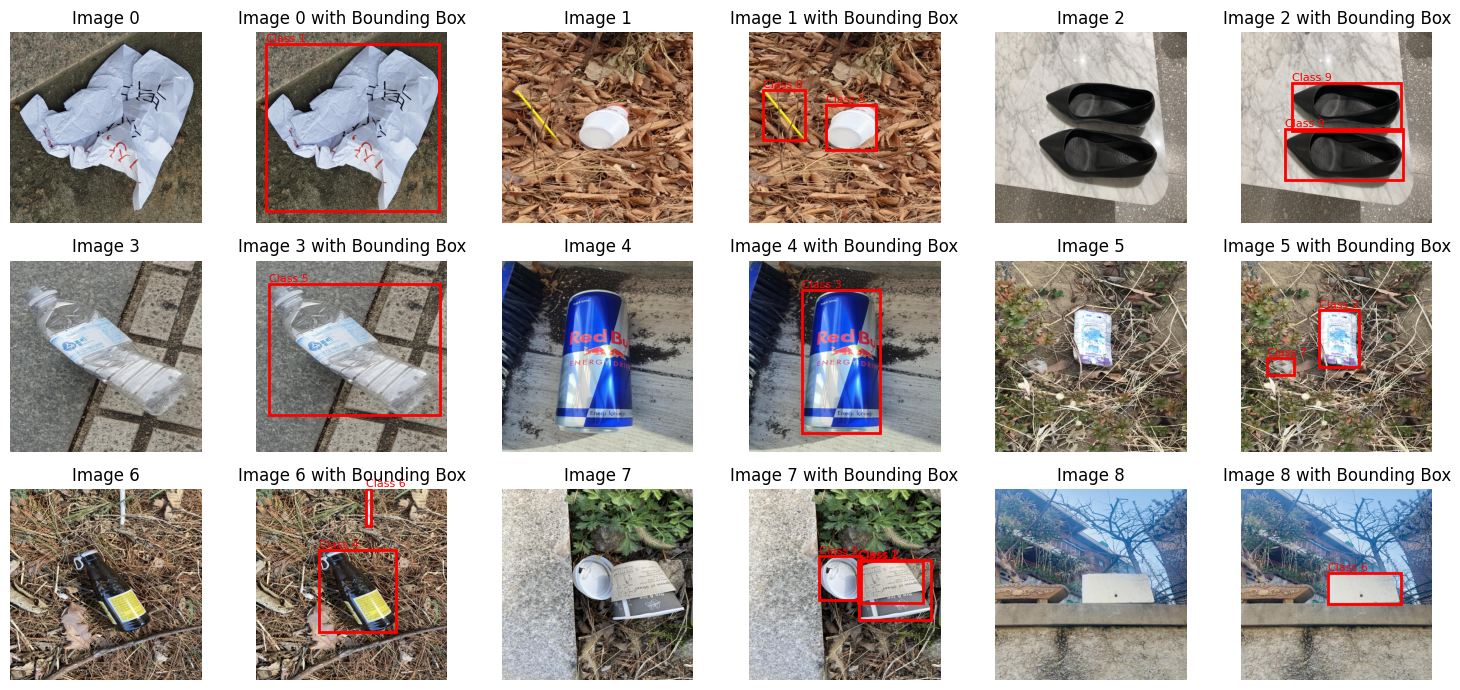

In [41]:
# JSON 파일에서 이미지 및 바운딩 박스 정보 읽기
with open(source, 'r') as json_file:
    data = json.load(json_file)

images = data['images']
annotations = data['annotations']

# 랜덤으로 9개 이미지 선택
selected_images = random.sample(images, 9)

# 이미지와 바운딩 박스를 함께 플로팅
plt.figure(figsize=(15, 7))

for i, image_info in enumerate(selected_images):
    annotation_info = [anno for anno in annotations if anno['image_id'] == image_info['id']]

    # 왼쪽에 기존 사진 플로팅
    plt.subplot(3, 6, i * 2 + 1)
    img_path = os.path.join(image_dir, image_info['file_name'])
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f'Image {i}')
    plt.axis('off')

    # 오른쪽에 바운딩 박스와 합친 사진 플로팅
    plt.subplot(3, 6, i * 2 + 2)
    plt.imshow(img)

    for bbox_info in annotation_info:
        bbox = bbox_info['bbox']
        category_id = bbox_info['category_id']

        # 바운딩 박스 그리기
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                 linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(bbox[0], bbox[1], f'Class {category_id}', color='r', fontsize=8, verticalalignment='bottom')

    plt.title(f'Image {i} with Bounding Box')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 각 클래스 별 객체 수 

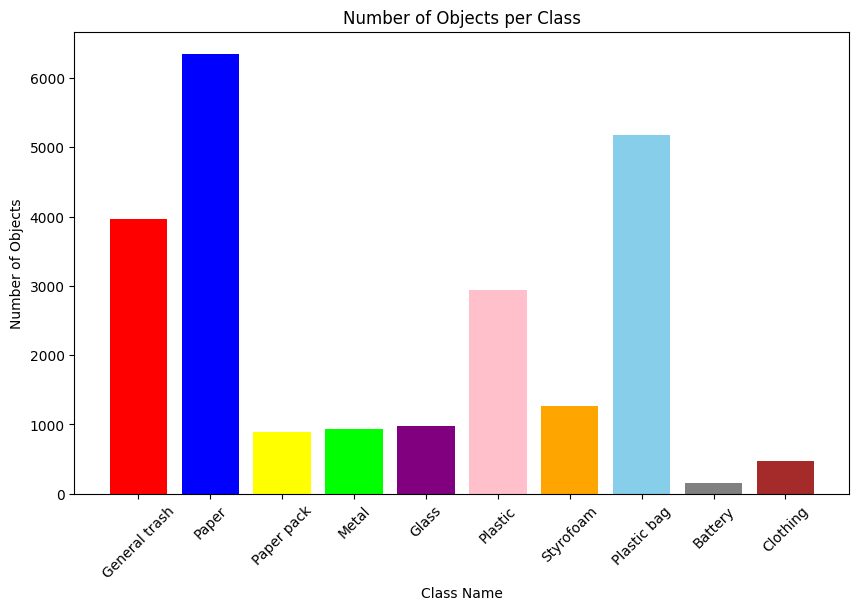

In [42]:
import matplotlib.pyplot as plt

# 클래스 ID에 따라 클래스 이름 매핑
class_id_to_name = {category['id']: category['name'] for category in categories}

# 클래스 별 객체 수 계산
class_counts = Counter([ann['category_id'] for ann in annotations])
bar_colors = [(r/255, g/255, b/255) for r, g, b in (class_colors.get(class_id, (0, 0, 0)) for class_id in class_ids)]


# 막대 그래프를 위한 데이터 준비
class_ids = list(class_id_to_name.keys())
counts = [class_counts[class_id] for class_id in class_ids]
class_names = [class_id_to_name[class_id] for class_id in class_ids]

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color=bar_colors)
plt.xlabel('Class Name')
plt.ylabel('Number of Objects')
plt.title('Number of Objects per Class')
plt.xticks(rotation=45)
plt.show()


### 이미지 별 객체 수

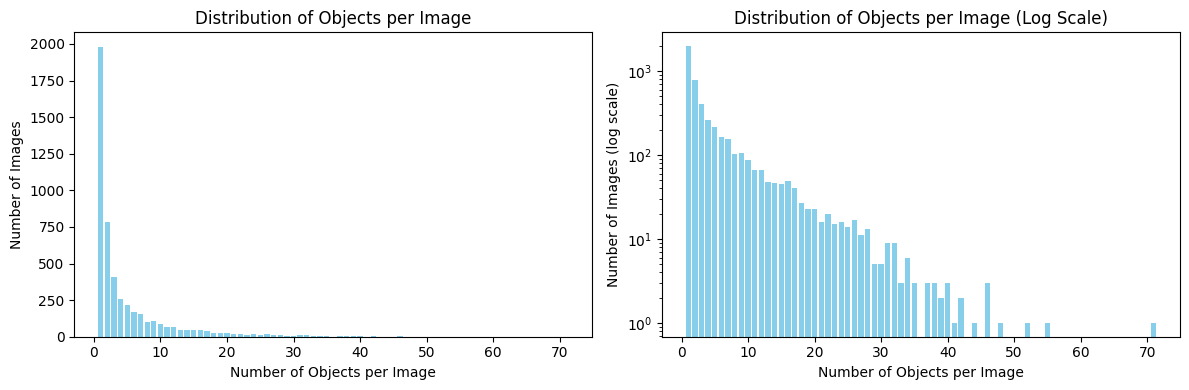

In [43]:
# 이미지당 객체 수 계산
object_counts_per_image = Counter([ann['image_id'] for ann in annotations])

# 객체 수 별 이미지 개수 계산
counts_per_object_number = Counter(object_counts_per_image.values())

# 막대 그래프를 위한 데이터 준비
object_numbers = list(counts_per_object_number.keys())
image_counts = [counts_per_object_number[object_number] for object_number in object_numbers]

# 막대 그래프 생성
plt.figure(figsize=(12,4))

# 일반 막대 그래프
plt.subplot(1, 2, 1)
plt.bar(object_numbers, image_counts, color='skyblue')
plt.xlabel('Number of Objects per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Objects per Image')

# 로그 스케일 막대 그래프
plt.subplot(1, 2, 2)
plt.bar(object_numbers, image_counts, color='skyblue', log=True)
plt.xlabel('Number of Objects per Image')
plt.ylabel('Number of Images (log scale)')
plt.title('Distribution of Objects per Image (Log Scale)')

plt.tight_layout()
plt.show()


### 각 클래스 별 width, height 분포 

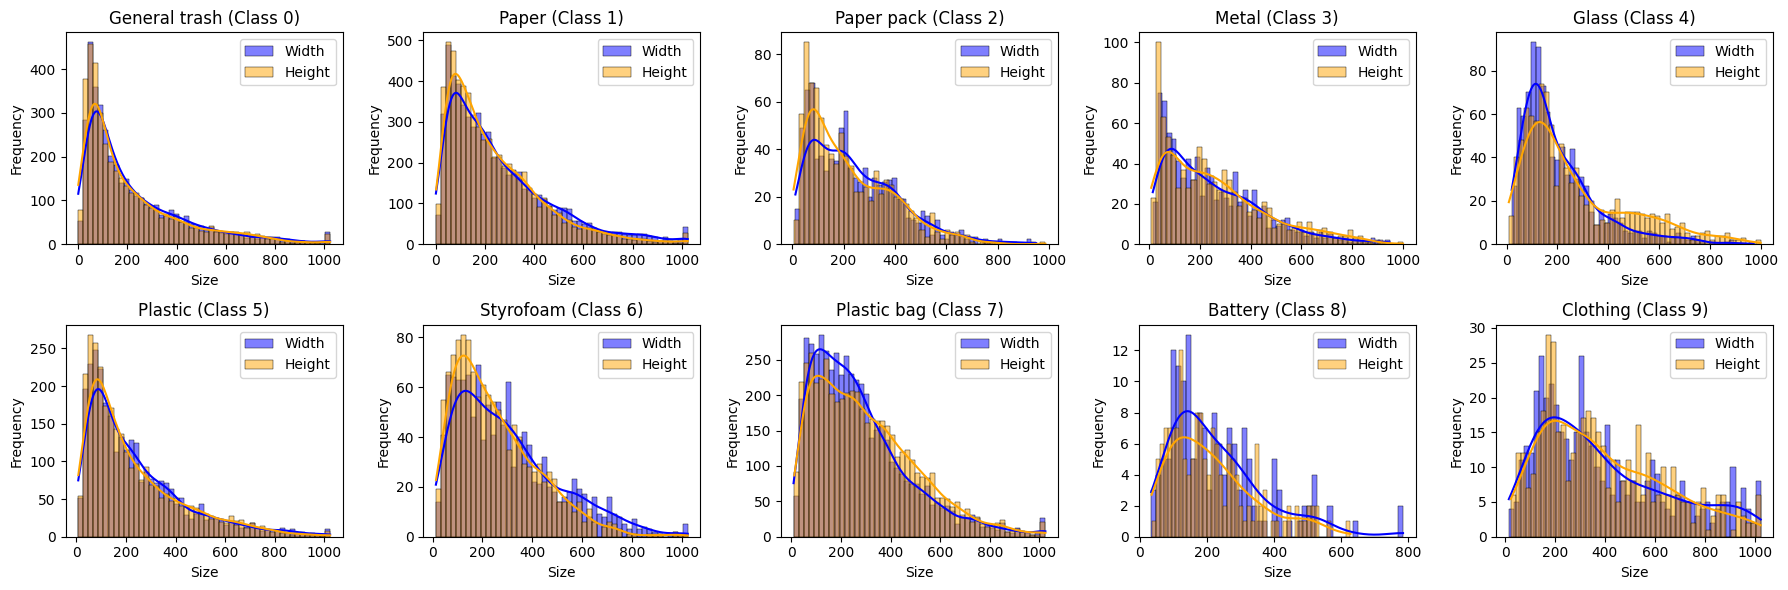

In [44]:
# 클래스 별 바운딩 박스의 가로 및 세로 크기 정보 추출
class_bbox_widths = {category['id']: [] for category in categories}
class_bbox_heights = {category['id']: [] for category in categories}

for annotation in annotations:
    category_id = annotation['category_id']
    class_bbox_widths[category_id].append(annotation['bbox'][2])
    class_bbox_heights[category_id].append(annotation['bbox'][3])


# 클래스별로 바운딩 박스의 가로 및 세로 크기 분포 확인
plt.figure(figsize=(18, 6))

class_names = {category['id']: category['name'] for category in categories}


for i, (category_id, name) in enumerate(class_names.items(), start=1):
    plt.subplot(2, len(class_names)//2, i)
    sns.histplot(class_bbox_widths[category_id], bins=50, kde=True, color='blue', label='Width')
    sns.histplot(class_bbox_heights[category_id], bins=50, kde=True, color='orange', label='Height')
    plt.title(f'{name} (Class {category_id})')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

### 각 클래스 별 width/height Ratio

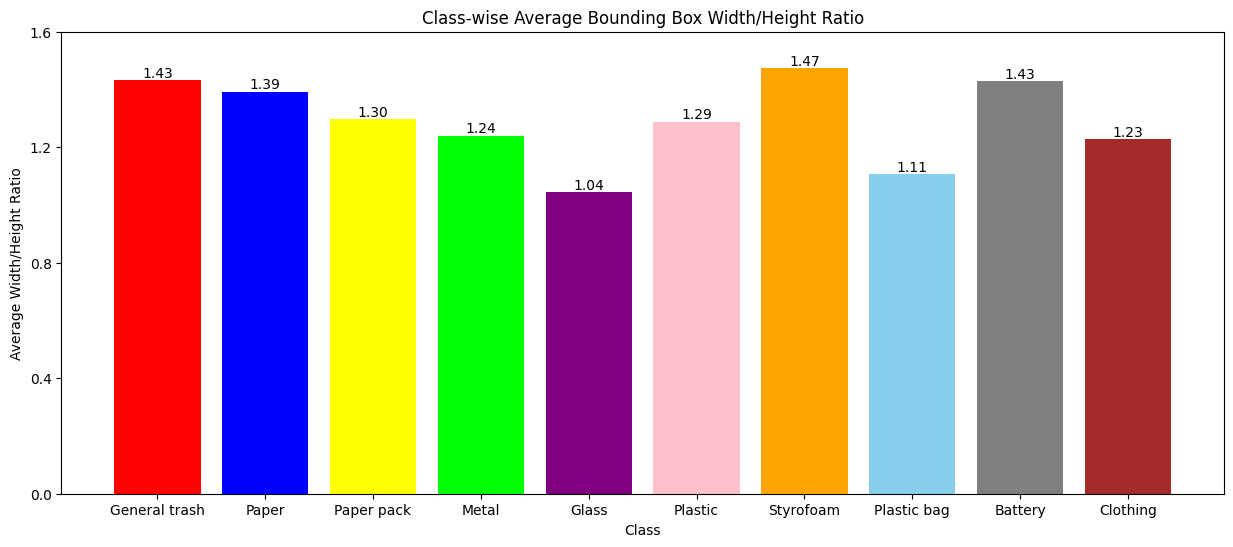

In [45]:
plt.figure(figsize=(15, 6))

# 클래스별로 고유한 컬러 정의
bar_colors = [normalized_class_colors[i % len(normalized_class_colors)] for i, category_id in enumerate(class_bbox_widths.keys())]

for i, category_id in enumerate(class_bbox_widths.keys()):
    widths = class_bbox_widths[category_id]
    heights = class_bbox_heights[category_id]
    ratios = [w / h for w, h in zip(widths, heights) if h != 0]

    avg_ratio = np.mean(ratios)

    # Bar를 그린 후, Bar 상단에 비율을 출력
    bar = plt.bar(class_names[category_id], avg_ratio, color=bar_colors[i])
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, avg_ratio, f'{avg_ratio:.2f}', ha='center', va='bottom')

plt.title('Class-wise Average Bounding Box Width/Height Ratio')
plt.xlabel('Class')
plt.ylabel('Average Width/Height Ratio')
plt.yticks([0, 0.4, 0.8, 1.2, 1.6])  # X 축 눈금을 원하는 값으로 설정
plt.show()


### 각 클래스 별 weight, height 산점도

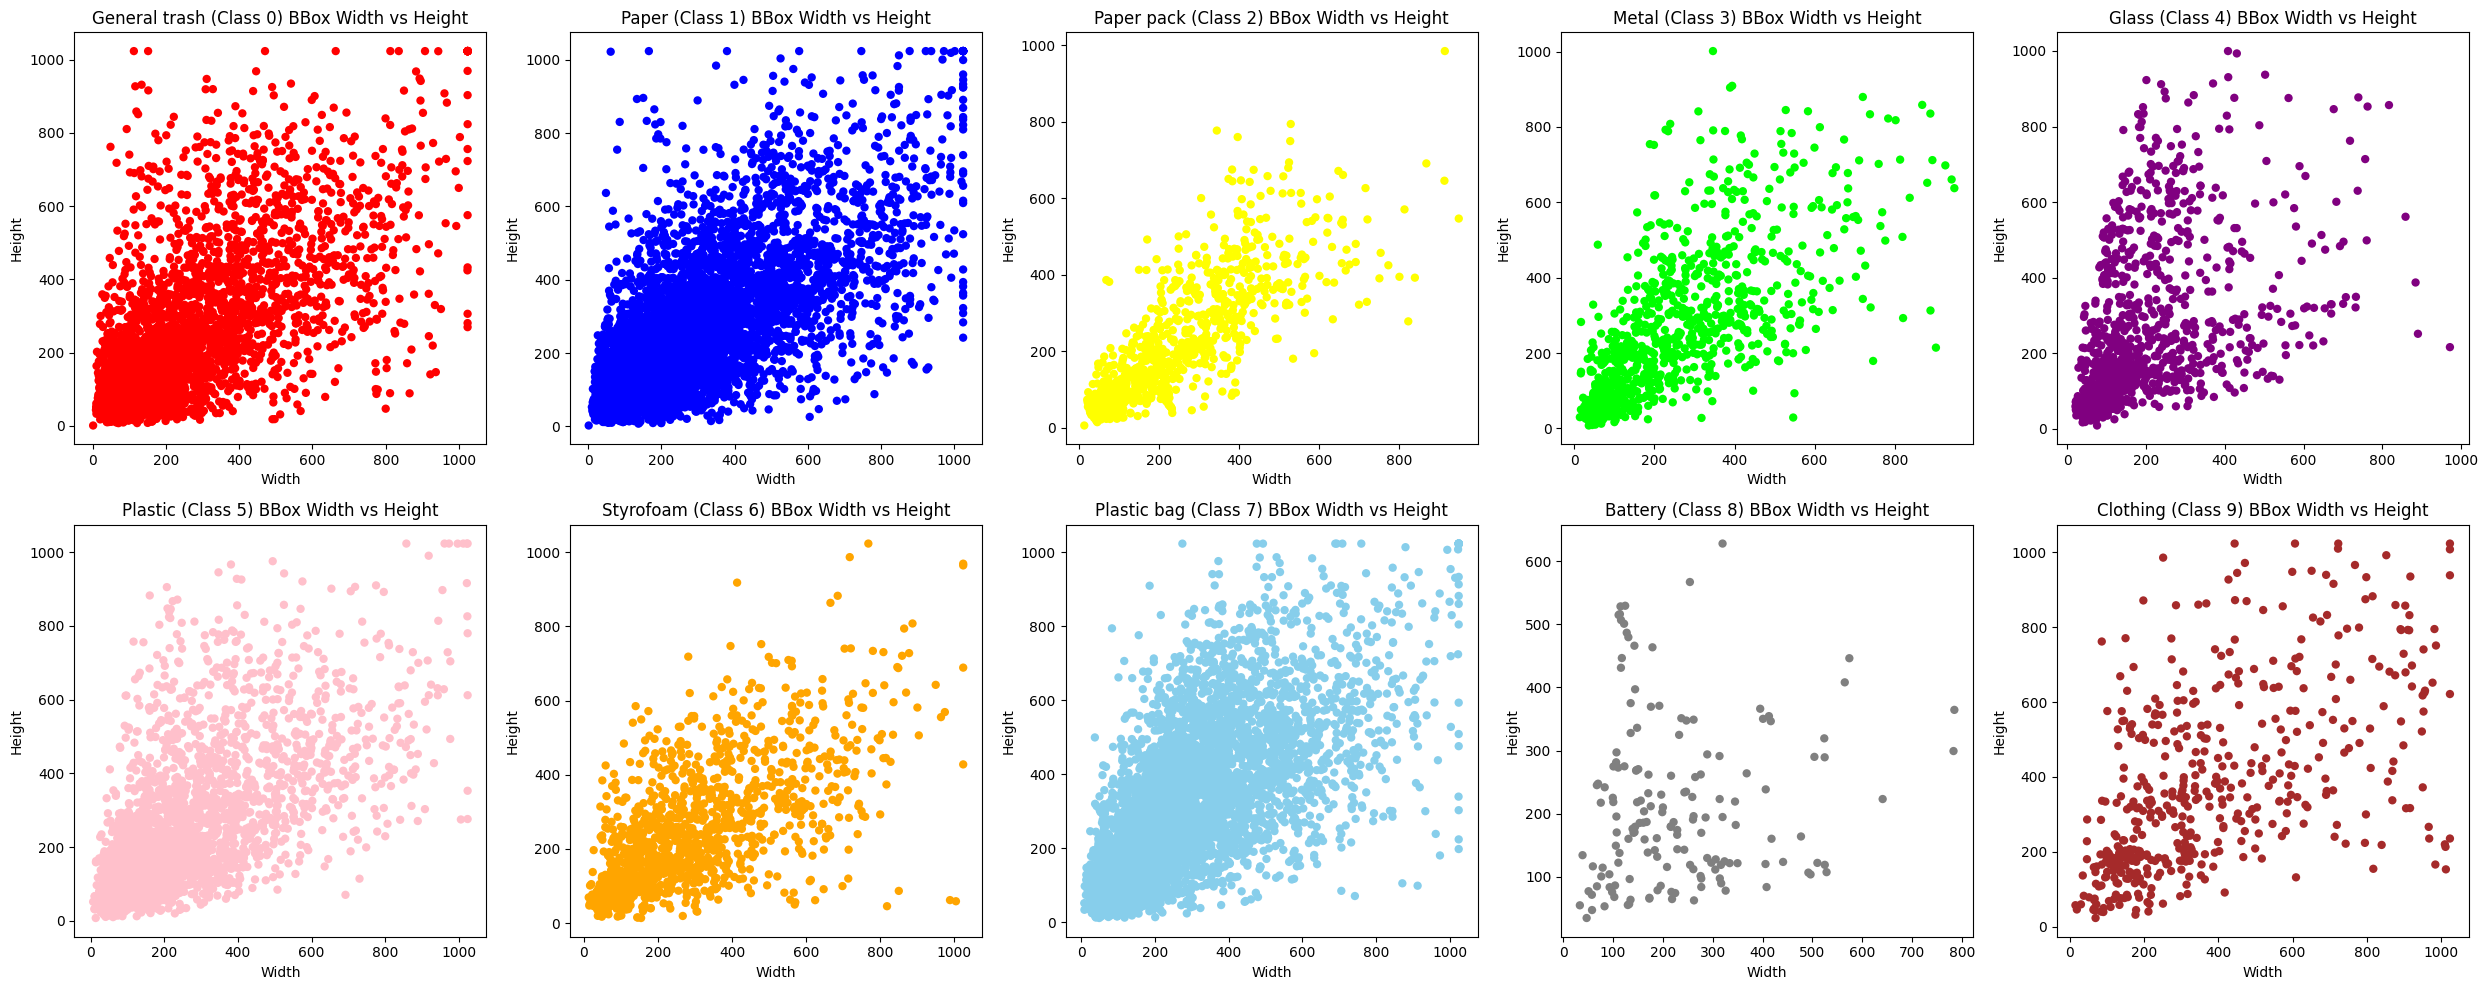

In [46]:
def bbox_scatter_plot():
    # 클래스 ID에 따라 클래스 이름 매핑
    class_id_to_name = {category['id']: category['name'] for category in categories}

    # 서브플롯 그리드 생성 (2x5)
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))

    for i, class_id in enumerate(class_ids):
        # 현재 클래스에 대한 바운딩 박스 데이터 추출
        bboxes = [ann['bbox'] for ann in annotations if ann['category_id'] == class_id]
        widths = [bbox[2] for bbox in bboxes]
        heights = [bbox[3] for bbox in bboxes]

        # 서브플롯 설정
        ax = axes[i // 5, i % 5]  # i번째 클래스에 대한 서브플롯 위치 계산
        sns.scatterplot(x=widths, y=heights, color=normalized_class_colors[class_id], edgecolor='none', ax=ax)
        ax.set_xlabel("Width")
        ax.set_ylabel("Height")
        ax.set_title(f"{class_id_to_name[class_id]} (Class {class_id}) BBox Width vs Height")

    # 빈 서브플롯 숨기기
    for i in range(len(class_ids), 10):
        axes[i // 5, i % 5].axis('off')

    plt.tight_layout()
    plt.show()

bbox_scatter_plot()


### bbox의 width, height가 이미지의 1/5 보다 작은 경우

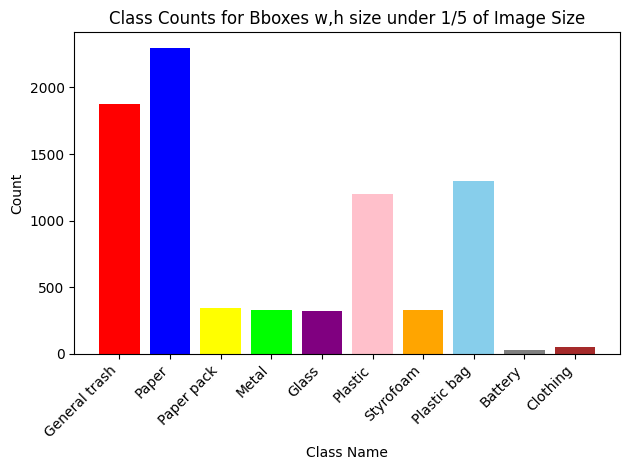

In [47]:

def get_random_color():
    return tuple(random.randint(0, 255) for _ in range(3))

def analyze_bbox_sizes(data):
    class_counts = {}

    for annotation in data['annotations']:
        bbox = annotation['bbox']

        # Bbox 가로 세로 길이가 이미지의 1/5 미만인 경우
        if bbox[2] < 1/5*YOUR_IMAGE_WIDTH and bbox[3] < 1/5*YOUR_IMAGE_HEIGHT:
            class_id = annotation['category_id']
            class_counts[class_id] = class_counts.get(class_id, 0) + 1

    return class_counts

def visualize_class_counts(class_counts, class_colors, categories):
    sorted_class_ids = sorted(class_counts.keys())
    class_names = [categories[i]['name'] for i in sorted_class_ids]
    counts = [class_counts[i] for i in sorted_class_ids]
    colors = [class_colors[i] for i in sorted_class_ids]

    # 클래스별 카운트 그래프 시각화
    plt.bar(class_names, counts, color=colors)
    plt.xlabel('Class Name')
    plt.ylabel('Count')
    plt.title('Class Counts for Bboxes w,h size under 1/5 of Image Size')
    plt.xticks(rotation=45, ha='right')  # 클래스 이름이 길 경우에 회전하여 표시
    plt.tight_layout()
    plt.show()


# 이미지의 가로 세로 크기 설정 (YOUR_IMAGE_WIDTH, YOUR_IMAGE_HEIGHT)
YOUR_IMAGE_WIDTH = 1024
YOUR_IMAGE_HEIGHT = 768

# Bbox 가로 세로 길이가 이미지의 1/5 미만인 경우의 클래스 count
class_counts = analyze_bbox_sizes(data)

# 클래스에 대응하는 랜덤 컬러 생성
class_colors = {class_id: class_colors.get(class_id, get_random_color()) for class_id in class_counts.keys()}


# 결과 그래프 시각화
visualize_class_counts(class_counts, bar_colors, categories)



### bbox area별 분포 히스토그램

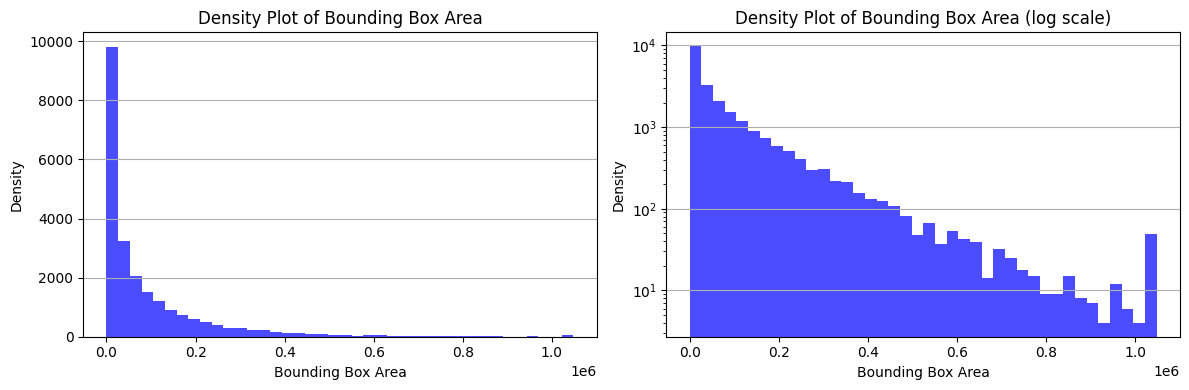

In [48]:
# Extract bbox sizes and calculate area
bbox_areas = [annotation['bbox'][2] * annotation['bbox'][3] for annotation in annotations]

# 첫 번째 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프 위치
plt.hist(bbox_areas, bins=40, alpha=0.7, color='blue')
plt.xlabel('Bounding Box Area')
plt.ylabel('Density')
plt.title('Density Plot of Bounding Box Area')
plt.grid(axis='y')

# 두 번째 그래프
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프 위치
plt.hist(bbox_areas, bins=40, alpha=0.7, color='blue')
plt.xlabel('Bounding Box Area')
plt.ylabel('Density')
plt.title('Density Plot of Bounding Box Area (log scale)')
plt.grid(axis='y')
plt.yscale('log')

plt.tight_layout()  # 그래프 간격 조정
plt.show()



### bbox area 별 분포 

In [49]:
import math

def cumulative_bbox_width_distribution():
    area_category = [64**2, 128**2, 256**2, 512**2]
    counting = [0] * 4
    for i , ann in enumerate(annotations):
        area = ann['area']
        if area <= 64**2:
            counting[0]+=1
        if area <= 128**2:
            counting[1] += 1
        if area <= 256**2:
            counting[2] += 1
        if area<= 512**2:
            counting[3] += 1

    # 각 범주별로 누적 개수 출력
    print("너비    누적 개수")
    for i in range(4):
        print(f'{int(math.sqrt(area_category[i]))}x{int(math.sqrt(area_category[i]))}\t{counting[i]}')

    # 전체 바운딩 박스 개수 출력
    total_bbox_count = len(annotations)
    print(f'Total\t{total_bbox_count}')

cumulative_bbox_width_distribution()


너비    누적 개수
64x64	3018
128x128	7671
256x256	14153
512x512	20990
Total	23144
